原始数据形状: (10980, 16)
IPCC区域地理数据加载成功
正在为岛屿分配IPCC区域...
区域分配完成，涉及区域: 43

=== 筛选在Climate Stress和TP2050之间有分类变化的岛屿 ===
满足数量阈值的有效区域 (岛屿数量>10): 39 个
有效区域内的岛屿数: 1825
=== 使用统一的output_0中位数基准进行所有情景的六区域分类 ===
全局基准 - 盈亏平衡电价中位数: 0.197
情景 output_2050: 有效岛屿数 1826
情景 output_future_2030: 有效岛屿数 1826
情景 output_future_2040: 有效岛屿数 1826
情景 output_future_2050: 有效岛屿数 1826
四个情景共同存在的岛屿数量: 1825
在Climate Stress和TP2050之间发生分类变化的岛屿数量: 50
最终用于桑基图的岛屿数: 50

=== 最终桑基图数据摘要 ===
桑基图数据准备完成，包含 50 个岛屿
涉及区域: 9 个
区域列表: ['EAS', 'MED', 'NZ', 'SAS', 'SAU', 'SCA', 'SEA', 'SSA', 'SWS']


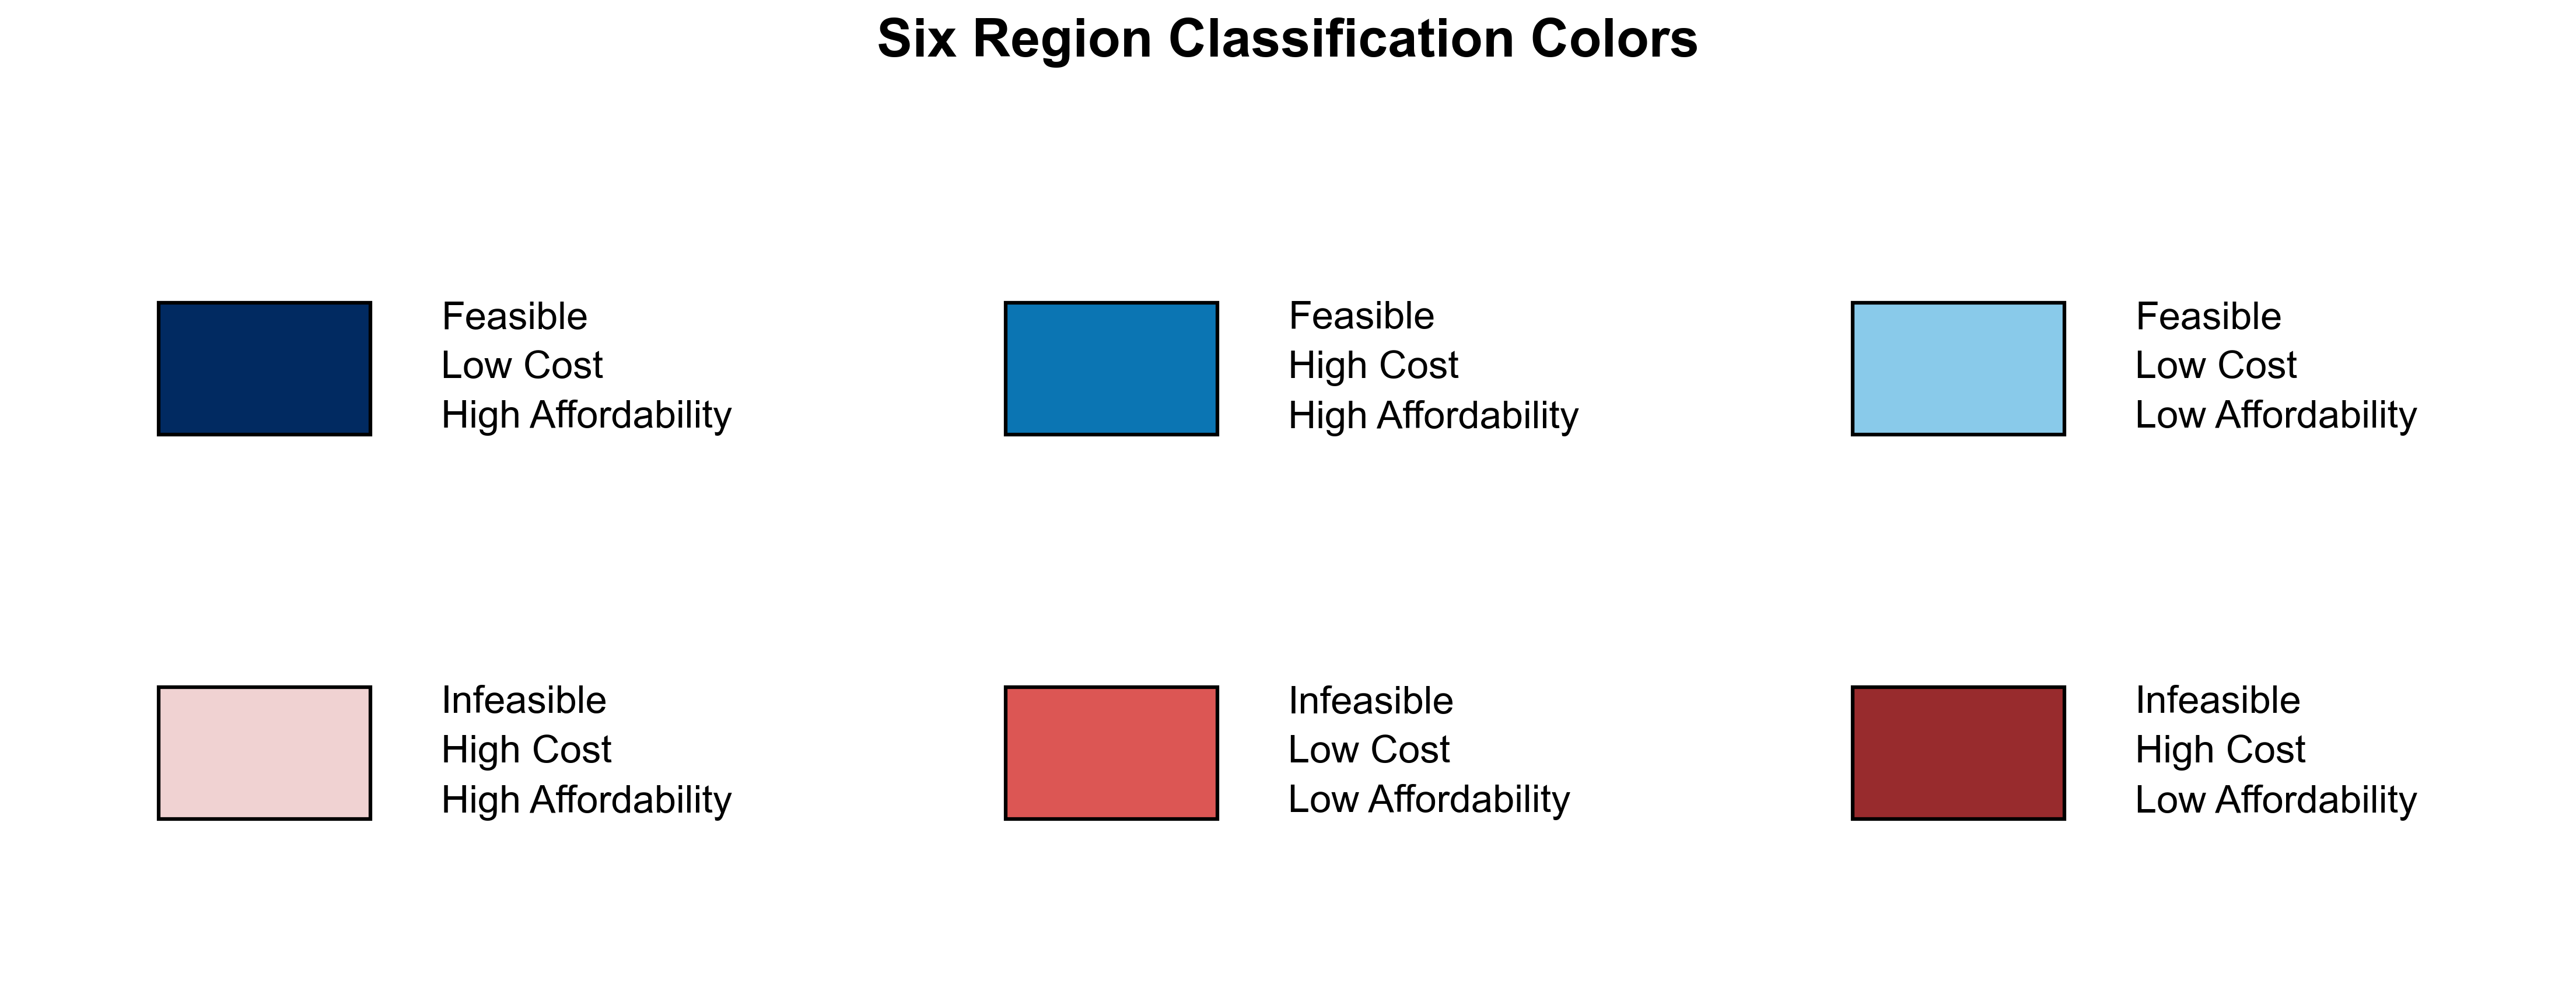

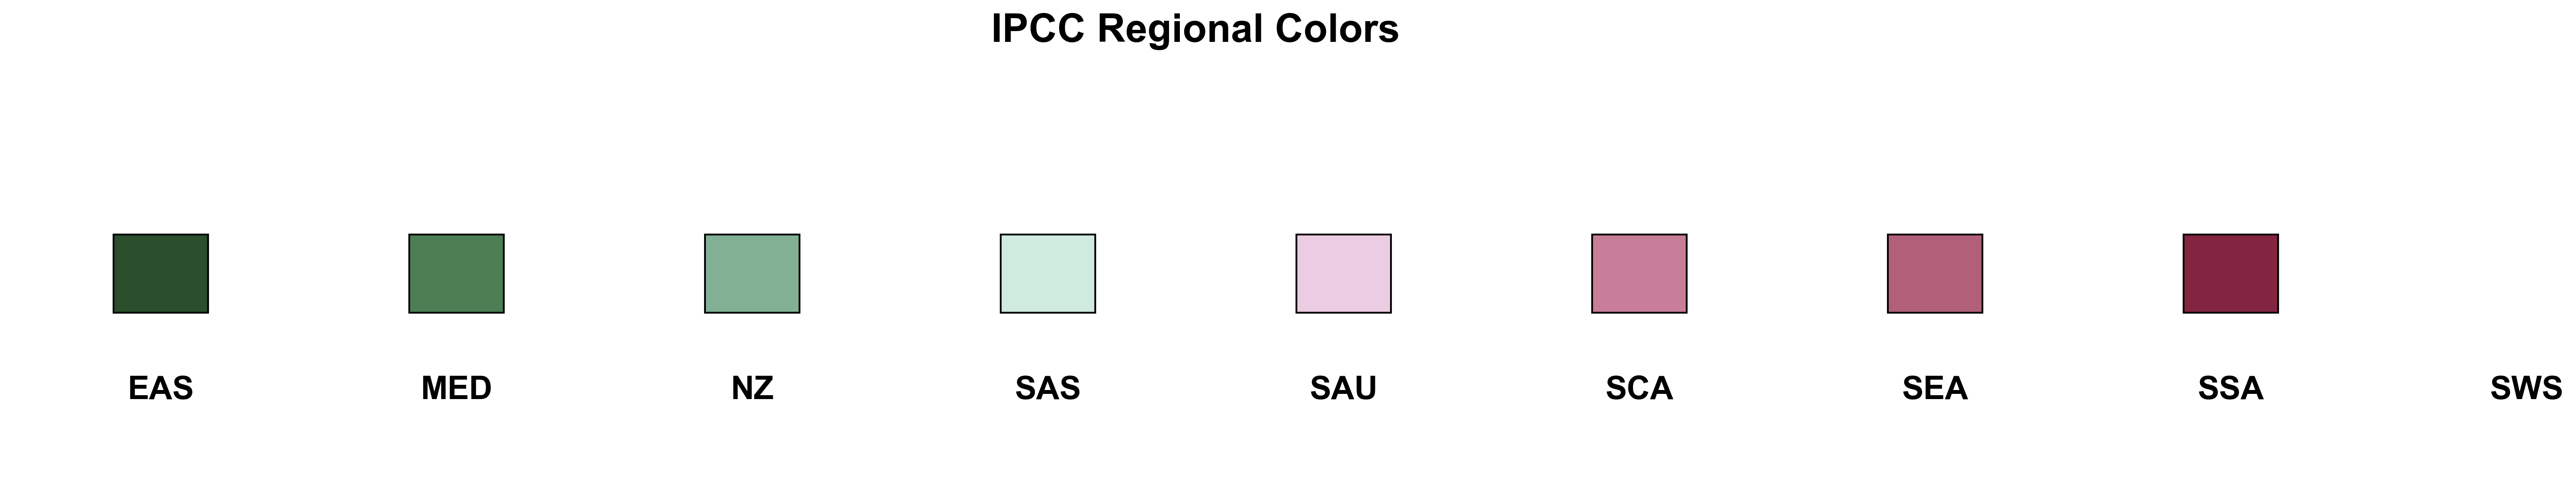

In [1]:
# 使用 floweaver 和 holoviews 创建五列连续桑基图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import matplotlib

# 设置全局字体为Arial
plt.rcParams.update({
    'font.family': 'Arial',  # 设置字体为Arial
    'font.size': 16,  # 基础字体大小
})

# =============================================================================
# 数据预处理部分 - 五个情景的五列桑基图数据准备
# =============================================================================

# 1. 读取岛屿可行性分析数据
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)  # 加载原始数据
print(f"原始数据形状: {df.shape}")  # 显示数据维度信息

# 2. 加载IPCC区域地理数据用于区域分配
try:
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")  # 加载IPCC区域边界数据
    ipcc_regions.sindex  # 创建空间索引以加速地理查询
    print("IPCC区域地理数据加载成功")
except Exception as e:
    print(f"无法加载IPCC区域数据: {e}")
    ipcc_regions = None

# 3. 定义IPCC区域分配函数（高效版本）
def assign_ipcc_region_optimized(lat, lon, ipcc_regions_gdf):
    """使用空间索引高效地将坐标分配到IPCC区域"""
    point = Point(lon, lat)  # 创建点几何对象
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))  # 空间索引快速筛选
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]  # 获取可能匹配的区域
    precise_matches = possible_matches[possible_matches.contains(point)]  # 精确几何匹配
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']  # 返回区域简称
    return 'Unknown'  # 未匹配到区域时返回Unknown

# 4. 为整个数据集分配IPCC区域
if ipcc_regions is not None:
    print("正在为岛屿分配IPCC区域...")
    df['ipcc_region'] = df.apply(
        lambda row: assign_ipcc_region_optimized(row['lat'], row['lon'], ipcc_regions), axis=1
    )  # 应用区域分配函数
    print(f"区域分配完成，涉及区域: {df['ipcc_region'].nunique()}")
else:
    df['ipcc_region'] = 'Unknown'  # 如果没有区域数据，设为Unknown

# =============================================================================
# 5. 筛选在Climate Stress和TP2050之间有分类变化的岛屿
# =============================================================================

print("\n=== 筛选在Climate Stress和TP2050之间有分类变化的岛屿 ===")

# 首先应用区域数量阈值
MIN_ISLANDS_PER_REGION = 10  # 每个区域最少岛屿数量阈值
region_counts = df['ipcc_region'].value_counts()  # 统计各区域岛屿数量
valid_regions = region_counts[region_counts > MIN_ISLANDS_PER_REGION].index.tolist()  # 筛选有效区域

print(f"满足数量阈值的有效区域 (岛屿数量>{MIN_ISLANDS_PER_REGION}): {len(valid_regions)} 个")

# 筛选有效区域的岛屿
df_valid_regions = df[df['ipcc_region'].isin(valid_regions)].copy()
print(f"有效区域内的岛屿数: {len(df_valid_regions['island_id'].unique())}")


# <<< MODIFICATION 1: Replace classification model >>>
# --- 六区域定义 ---
SIX_REGION_NAMES = [
    "Feasible\nLow Cost\nHigh Affordability",      # 区域1
    "Feasible\nHigh Cost\nHigh Affordability",     # 区域2
    "Feasible\nLow Cost\nLow Affordability",       # 区域3
    "Infeasible\nHigh Cost\nHigh Affordability",   # 区域4
    "Infeasible\nLow Cost\nLow Affordability",     # 区域5
    "Infeasible\nHigh Cost\nLow Affordability",    # 区域6
]

# --- 核心分类函数 (六区域模型) ---
def classify_six_regions(row, median_breakeven):
    """根据成本中位数和可行性对单个点进行六区域分类"""
    x = row['tariff_breakeven']
    y = row['tariff_affordable']
    
    is_low_cost = x <= median_breakeven
    is_high_affordability_benchmark = y > median_breakeven
    is_feasible = y >= x
    
    if is_feasible:
        if is_low_cost and is_high_affordability_benchmark: return SIX_REGION_NAMES[0]
        elif not is_low_cost and is_high_affordability_benchmark: return SIX_REGION_NAMES[1]
        elif is_low_cost and not is_high_affordability_benchmark: return SIX_REGION_NAMES[2]
        else: return SIX_REGION_NAMES[5]  # Feasible, High Cost, Low Affordability
    else: # Infeasible
        if not is_low_cost and is_high_affordability_benchmark: return SIX_REGION_NAMES[3]
        elif is_low_cost and not is_high_affordability_benchmark: return SIX_REGION_NAMES[4]
        else: return SIX_REGION_NAMES[5] # Infeasible, High Cost, Low Affordability

# =============================================================================
# 6. 处理五个情景的数据并计算统一的中位数分类基准
# =============================================================================

scenarios = ['output_2050', 'output_future_2030', 'output_future_2040', 'output_future_2050']  # 四个目标情景

# <<< MODIFICATION 2: Use a single median benchmark >>>
# 首先从output_0（Ideal情景）计算全局中位数基准
df_output_0 = df_valid_regions[df_valid_regions['scenario'] == 'output_0'].copy()
global_median_breakeven = df_output_0['tariff_breakeven'].median()

print(f"=== 使用统一的output_0中位数基准进行所有情景的六区域分类 ===")
print(f"全局基准 - 盈亏平衡电价中位数: {global_median_breakeven:.3f}")

# 准备合并数据的列表
combined_data = []

# 为每个情景使用统一的全局中位数进行分类
for scenario in scenarios:
    df_scenario = df_valid_regions[df_valid_regions['scenario'] == scenario].copy()

    # <<< MODIFICATION 3: Call the new classification function >>>
    df_scenario['classification'] = df_scenario.apply(
        lambda row: classify_six_regions(row, global_median_breakeven), axis=1
    )

    print(f"情景 {scenario}: 有效岛屿数 {len(df_scenario)}")
    combined_data.append(df_scenario)

# 找到四个情景中共同存在的岛屿
common_islands = set(combined_data[0]['island_id'])
for df_scenario in combined_data[1:]:
    common_islands = common_islands.intersection(set(df_scenario['island_id']))
print(f"四个情景共同存在的岛屿数量: {len(common_islands)}")

# 筛选共同岛屿的数据
for i in range(len(combined_data)):
    combined_data[i] = combined_data[i][combined_data[i]['island_id'].isin(common_islands)].copy()

# 识别在Climate Stress和TP2050之间发生分类变化的岛屿
changed_island_ids = []
df_climate = combined_data[0]  # Climate Stress
df_tp2050 = combined_data[3]   # TP2050

for island_id in common_islands:
    # <<< MODIFICATION 4: Use the new 'classification' column for comparison >>>
    climate_class = df_climate[df_climate['island_id'] == island_id]['classification'].iloc[0]
    tp2050_class = df_tp2050[df_tp2050['island_id'] == island_id]['classification'].iloc[0]
    
    if climate_class != tp2050_class:
        changed_island_ids.append(island_id)

print(f"在Climate Stress和TP2050之间发生分类变化的岛屿数量: {len(changed_island_ids)}")

# 最终筛选：只保留发生变化的岛屿
for i in range(len(combined_data)):
    combined_data[i] = combined_data[i][combined_data[i]['island_id'].isin(changed_island_ids)].copy()

final_island_count = len(changed_island_ids)
print(f"最终用于桑基图的岛屿数: {final_island_count}")

# =============================================================================
# 7. 创建五列桑基图的数据结构
# =============================================================================

def prepare_five_column_sankey_data(df_list):
    """为五列桑基图准备数据"""
    sankey_data = []

    for island_id in changed_island_ids:
        island_info = {}
        for i, df_scenario in enumerate(df_list):
            island_row = df_scenario[df_scenario['island_id'] == island_id].iloc[0]
            # <<< MODIFICATION 5: Use the new 'classification' column >>>
            island_info[f'scenario_{i}'] = {
                'region': island_row['ipcc_region'],
                'classification': island_row['classification']
            }

        sankey_data.append({
            'island_id': island_id,
            'region': island_info['scenario_0']['region'],
            'climate_class': island_info['scenario_0']['classification'],
            'tp2030_class': island_info['scenario_1']['classification'],
            'tp2040_class': island_info['scenario_2']['classification'],
            'tp2050_class': island_info['scenario_3']['classification']
        })

    return pd.DataFrame(sankey_data)

# =============================================================================
# 8. 准备桑基图数据
# =============================================================================

sankey_df = prepare_five_column_sankey_data(combined_data)
print(f"\n=== 最终桑基图数据摘要 ===")
print(f"桑基图数据准备完成，包含 {len(sankey_df)} 个岛屿")
print(f"涉及区域: {sankey_df['region'].nunique()} 个")
print(f"区域列表: {sorted(sankey_df['region'].unique())}")

# =============================================================================
# 9. 定义六区域分类颜色和图例
# =============================================================================

# <<< MODIFICATION 6: Update color definitions and legends for 6 regions >>>
# 定义六个主要类别的颜色
six_region_colors_hex = {
    SIX_REGION_NAMES[0]: '#012A61',
    SIX_REGION_NAMES[1]: '#0B75B3',
    SIX_REGION_NAMES[2]: '#89CAEA',
    SIX_REGION_NAMES[3]: "#F0D2D2",
    SIX_REGION_NAMES[4]: '#DC5654',
    SIX_REGION_NAMES[5]: '#982B2D',
}

# 为区域生成高对比度的不同颜色
def generate_distinct_region_colors(regions):
    """生成与六区域分类颜色高度区分的区域颜色"""
    distinct_region_colors = [
        "#2B4E2D", '#4d7e54', '#81b095', '#cfeadf',
        '#ebcce2', '#c87d98', '#b25f79', '#832440'
    ]
    region_colors_hex = {}
    for i, region in enumerate(regions):
        color_idx = i % len(distinct_region_colors)
        region_colors_hex[region] = distinct_region_colors[color_idx]
    return region_colors_hex

unique_regions = sorted(sankey_df['region'].unique())
region_colors_hex = generate_distinct_region_colors(unique_regions)

# --- 创建六区域分类图例 (2x3 网格布局) ---
import matplotlib.patches as patches

fig_class_legend, ax1 = plt.subplots(figsize=(15, 6), dpi=300)
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 8)
ax1.set_title('Six Region Classification Colors', fontsize=22, fontweight='bold', pad=20)

x_rect_positions = [1, 7, 13]
x_text_positions = [3, 9, 15]
y_positions = [5, 1.5]

# Sort the categories according to the predefined order for consistent plotting
sorted_categories = sorted(six_region_colors_hex.keys(), key=lambda k: SIX_REGION_NAMES.index(k))

for i, category in enumerate(sorted_categories):
    row_index = i // 3
    col_index = i % 3
    
    x_rect = x_rect_positions[col_index]
    x_text = x_text_positions[col_index]
    y_pos = y_positions[row_index]
    
    hex_color = six_region_colors_hex[category]
    
    rect = patches.Rectangle((x_rect, y_pos), 1.5, 1.2,
                             linewidth=1.5, edgecolor='black', facecolor=hex_color)
    ax1.add_patch(rect)
    
    ax1.text(x_text, y_pos + 0.6, category,
             fontsize=16, va='center', fontweight='normal', linespacing=1.5)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
plt.tight_layout()
plt.show()

# --- 创建区域颜色图例 (横向排列) ---
fig_region, ax2 = plt.subplots(figsize=(20, 4), dpi=300)
ax2.set_xlim(0, 20)
ax2.set_ylim(0, 2)
ax2.set_title('IPCC Regional Colors', fontsize=22, fontweight='bold', pad=20)

x_positions = [i * 2.5 + 1.25 for i in range(len(unique_regions))]

for i, region in enumerate(unique_regions):
    hex_color = region_colors_hex[region]
    rect = patches.Rectangle((x_positions[i]-0.4, 0.8), 0.8, 0.4,
                             linewidth=1, edgecolor='black', facecolor=hex_color)
    ax2.add_patch(rect)
    ax2.text(x_positions[i], 0.4, region,
             fontsize=18, ha='center', va='center', fontweight='bold')

ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
plt.tight_layout()
plt.show()

使用统一的六区域颜色配色方案
为 9 个区域生成了高对比度的区分色彩

                                    桑基图颜色图例                                     

🎨 六区域分类颜色（节点颜色）:
------------------------------------------------------------
 1. Feasible
      Low Cost
      High Affordability
      颜色代码: #012A61

 2. Feasible
      High Cost
      High Affordability
      颜色代码: #0B75B3

 3. Feasible
      Low Cost
      Low Affordability
      颜色代码: #89CAEA

 4. Infeasible
      High Cost
      High Affordability
      颜色代码: #F0D2D2

 5. Infeasible
      Low Cost
      Low Affordability
      颜色代码: #DC5654

 6. Infeasible
      High Cost
      Low Affordability
      颜色代码: #982B2D

🌍 IPCC区域颜色（流向颜色）:
------------------------------------------------------------
 1. EAS (包含 4 个变化岛屿)
     颜色代码: #012A61

 2. MED (包含 13 个变化岛屿)
     颜色代码: #015696

 3. NZ (包含 3 个变化岛屿)
     颜色代码: #0B75B3

 4. SAS (包含 7 个变化岛屿)
     颜色代码: #4596CD

 5. SAU (包含 3 个变化岛屿)
     颜色代码: #89CAEA

 6. SCA (包含 1 个变化岛屿)
     颜色代码: #EE9D9F

 7. SEA (包含 16 个变化岛屿)
     颜色

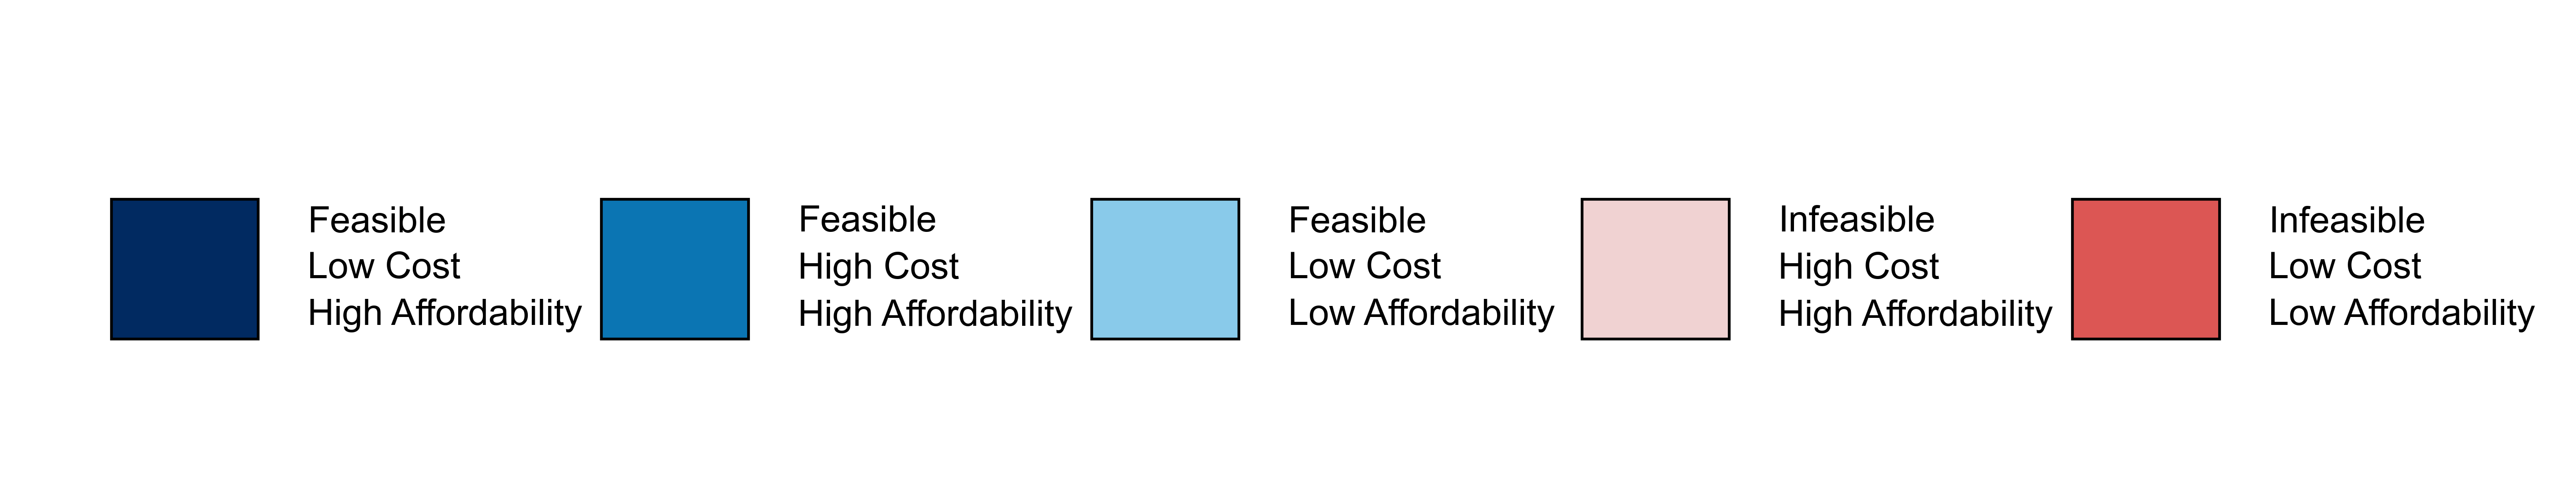

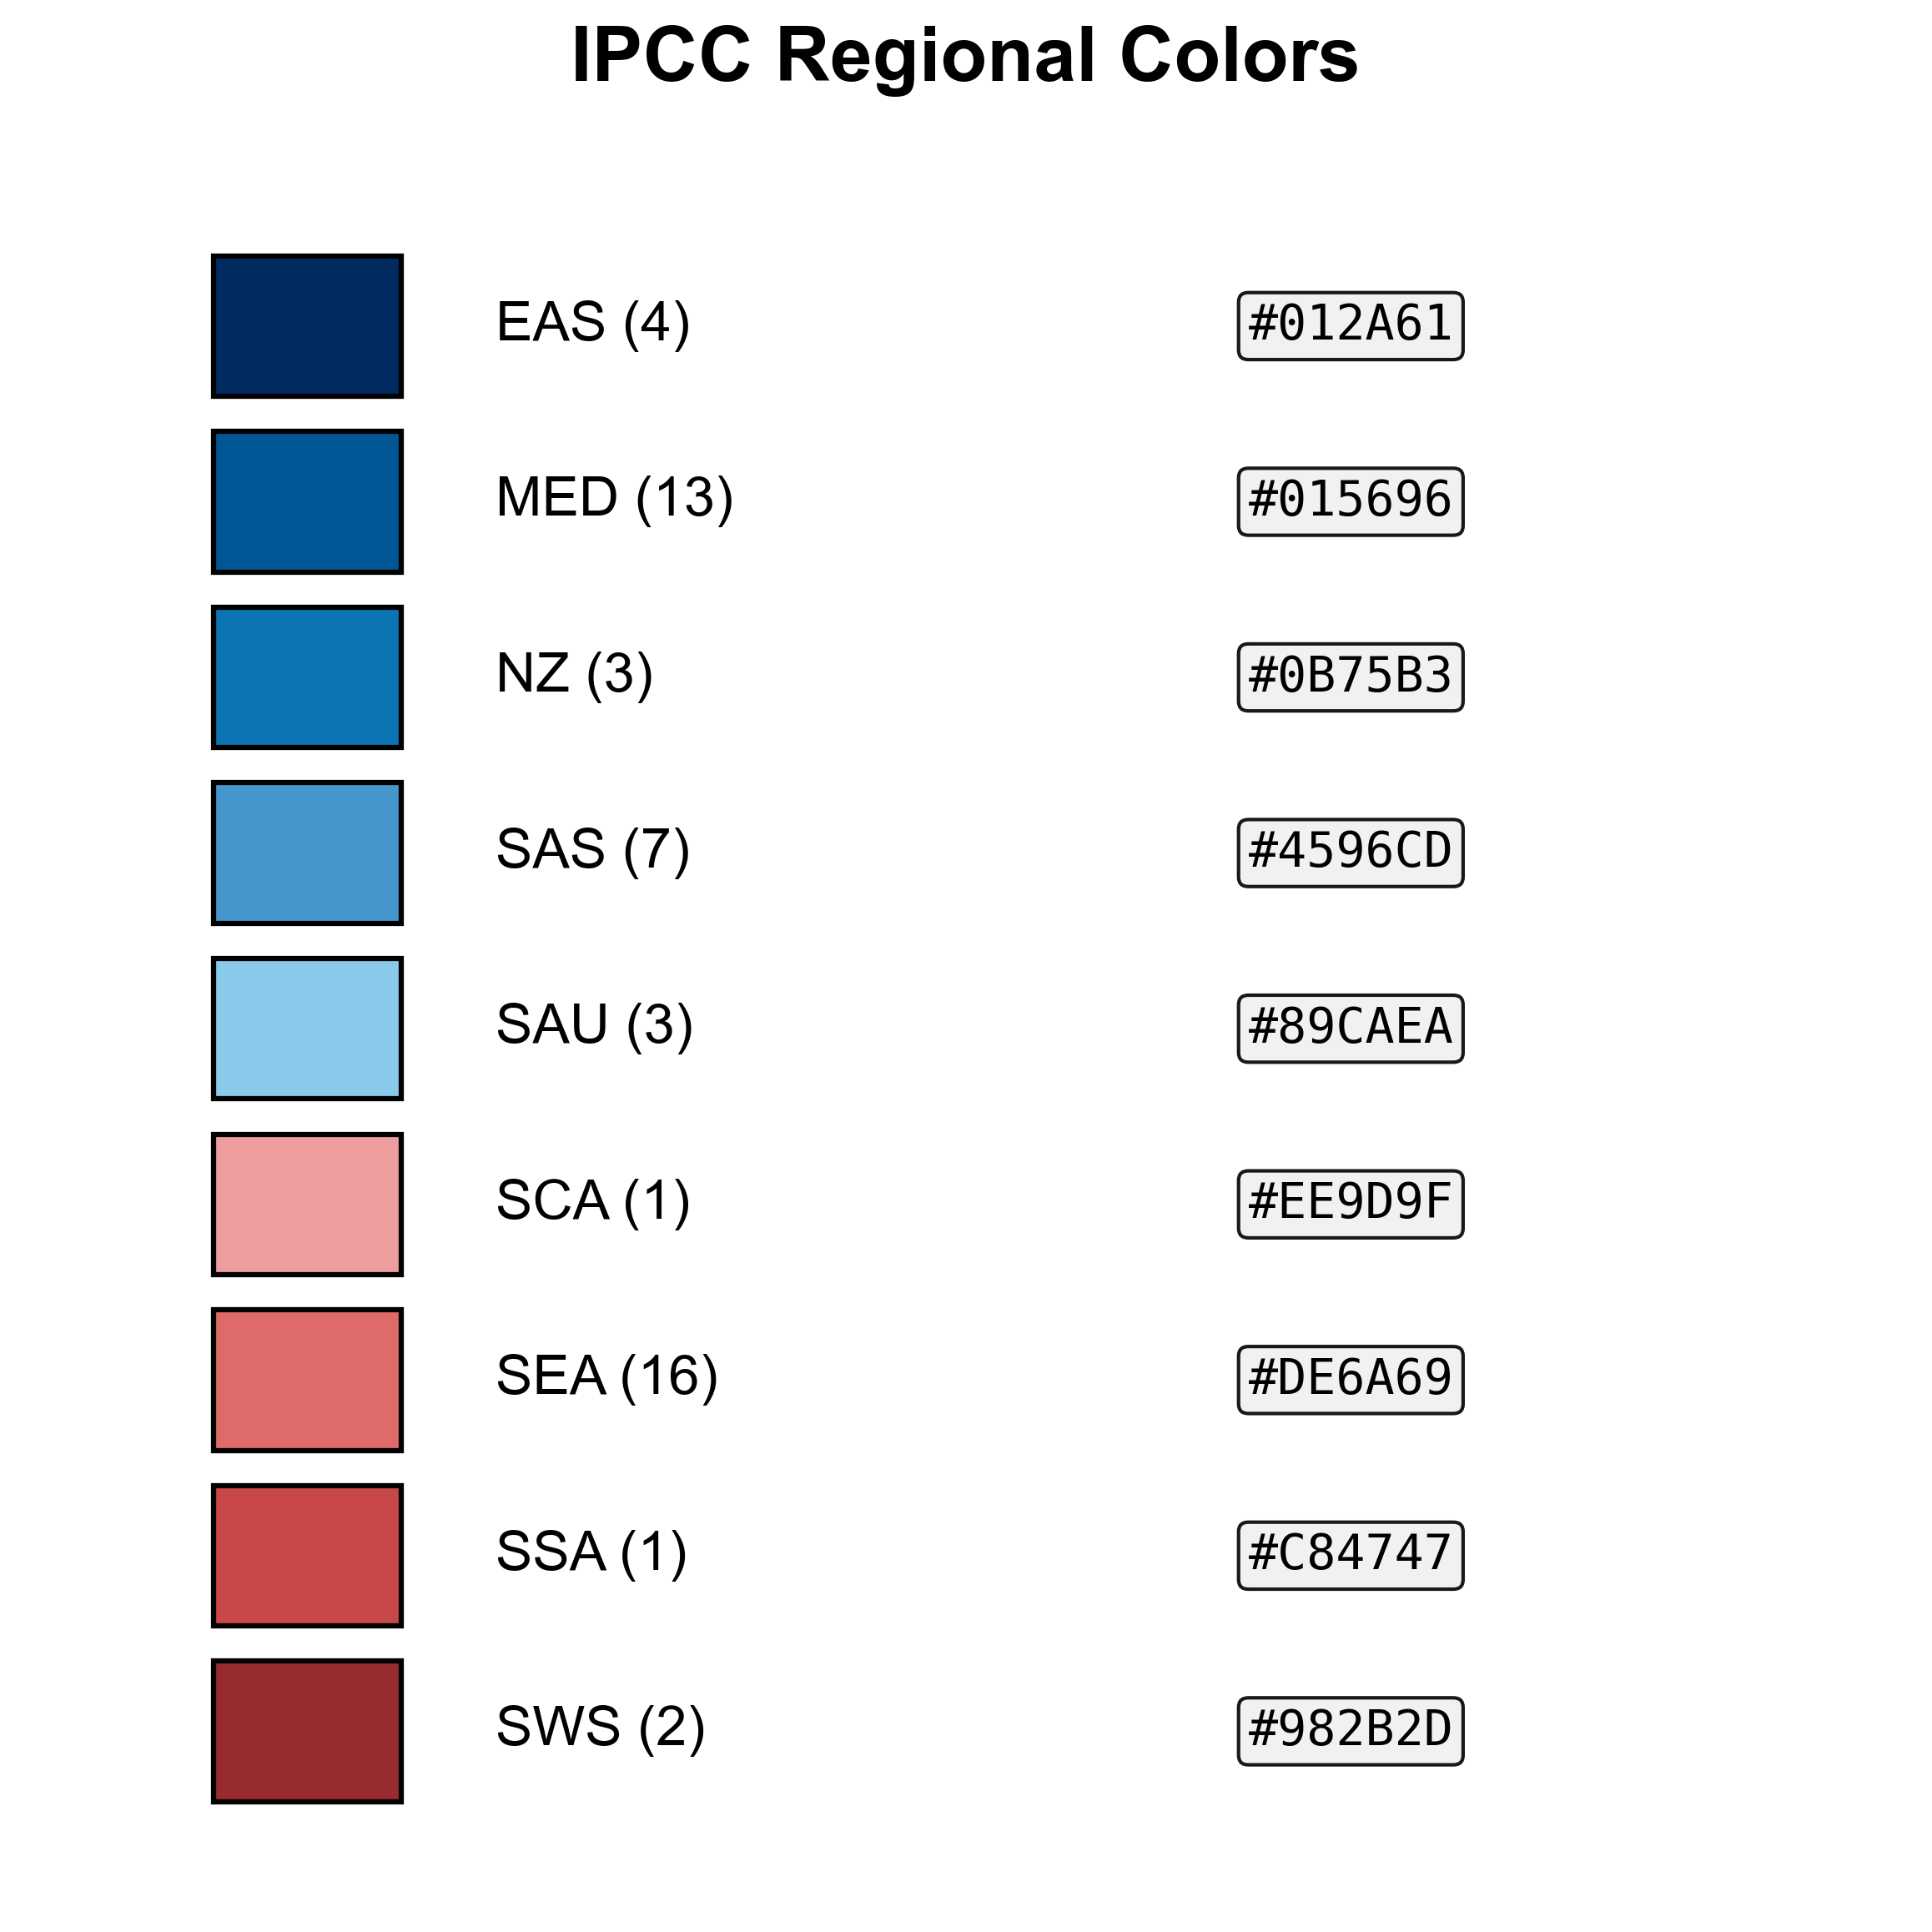

In [3]:
# Nature Communications风格五层桑基图：Region -> Climate Stress -> TP2030 -> TP2040 -> TP2050

import plotly.graph_objects as go  # 导入plotly桑基图绘制库
import plotly.io as pio  # 导入plotly IO库用于格式设置
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np  # 数值计算库

# 设置plotly默认样式为静态图，符合期刊要求
pio.renderers.default = "browser"  # 设置输出渲染器为浏览器

# =============================================================================
# 1. Nature风格颜色映射 - 使用统一的六区域分类颜色
# =============================================================================

# <<< MODIFIED: Define the six region names and colors >>>
SIX_REGION_NAMES = [
    "Feasible\nLow Cost\nHigh Affordability",
    "Feasible\nHigh Cost\nHigh Affordability",
    "Feasible\nLow Cost\nLow Affordability",
    "Infeasible\nHigh Cost\nHigh Affordability",
    "Infeasible\nLow Cost\nLow Affordability",
    "Infeasible\nHigh Cost\nLow Affordability",
]

six_region_colors_hex = {
    SIX_REGION_NAMES[0]: '#012A61',  # 深蓝 (最理想)
    SIX_REGION_NAMES[1]: '#0B75B3',  # 中蓝
    SIX_REGION_NAMES[2]: '#89CAEA',  # 浅蓝 (勉强可行)
    SIX_REGION_NAMES[3]: "#F0D2D2",  # 浅红 (成本问题)
    SIX_REGION_NAMES[4]: '#DC5654',  # 中红 (支付能力问题)
    SIX_REGION_NAMES[5]: '#982B2D',  # 深红 (最棘手)
}

# 转换为Plotly需要的rgba格式
def hex_to_rgba(hex_color, alpha=0.85):
    """将十六进制颜色转换为rgba格式"""
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16) 
    b = int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {alpha})'

# 转换六区域颜色为rgba格式
six_region_colors_rgba = {name: hex_to_rgba(color, 1) for name, color in six_region_colors_hex.items()}
print("使用统一的六区域颜色配色方案")

# 为区域生成高对比度的不同颜色
def generate_distinct_region_colors(regions):
    """生成与六区域颜色高度区分的区域颜色"""
    distinct_region_colors = [
        '#012A61', '#015696', '#0B75B3', '#4596CD',
        '#89CAEA', '#EE9D9F', '#DE6A69',
        '#C84747', '#982B2D', 
    ]
    region_colors = {}
    region_colors_hex = {}
    for i, region in enumerate(regions):
        color_idx = i % len(distinct_region_colors)
        hex_color = distinct_region_colors[color_idx]
        region_colors[region] = hex_to_rgba(hex_color, 0.55)
        region_colors_hex[region] = hex_color
    return region_colors, region_colors_hex

# 获取所有唯一区域并生成颜色
unique_regions = sorted(sankey_df['region'].unique())
region_colors, region_colors_hex = generate_distinct_region_colors(unique_regions)
print(f"为 {len(unique_regions)} 个区域生成了高对比度的区分色彩")

# =============================================================================
# 2. 构建五层桑基图的节点和链接数据结构
# =============================================================================

# <<< MODIFIED: Sort nodes by the predefined SIX_REGION_NAMES order >>>
# 定义五个层级的所有可能节点
all_regions = sorted(sankey_df['region'].unique())
all_climate_classes = sorted(sankey_df['climate_class'].unique(), key=SIX_REGION_NAMES.index)
all_tp2030_classes = sorted(sankey_df['tp2030_class'].unique(), key=SIX_REGION_NAMES.index)
all_tp2040_classes = sorted(sankey_df['tp2040_class'].unique(), key=SIX_REGION_NAMES.index)
all_tp2050_classes = sorted(sankey_df['tp2050_class'].unique(), key=SIX_REGION_NAMES.index)

# 创建节点标签和颜色列表
node_labels = []
node_colors = []

# 第1层：区域节点
for region in all_regions:
    node_labels.append("")
    node_colors.append(region_colors[region])

# <<< MODIFIED: Use six_region_colors_rgba for all classification nodes >>>
# 第2层：Climate Stress分类节点
for climate_class in all_climate_classes:
    node_labels.append("")
    node_colors.append(six_region_colors_rgba[climate_class])

# 第3层：TP2030分类节点
for tp2030_class in all_tp2030_classes:
    node_labels.append("")
    node_colors.append(six_region_colors_rgba[tp2030_class])

# 第4层：TP2040分类节点
for tp2040_class in all_tp2040_classes:
    node_labels.append("")
    node_colors.append(six_region_colors_rgba[tp2040_class])

# 第5层：TP2050分类节点
for tp2050_class in all_tp2050_classes:
    node_labels.append("")
    node_colors.append(six_region_colors_rgba[tp2050_class])

# 创建节点索引映射字典 (This logic is correct for 5 columns)
region_start_idx = 0
climate_start_idx = len(all_regions)
tp2030_start_idx = len(all_regions) + len(all_climate_classes)
tp2040_start_idx = len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes)
tp2050_start_idx = len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) + len(all_tp2040_classes)

def get_node_index(layer, item):
    """获取节点索引"""
    if layer == 'region':
        return all_regions.index(item)
    elif layer == 'climate':
        return climate_start_idx + all_climate_classes.index(item)
    elif layer == 'tp2030':
        return tp2030_start_idx + all_tp2030_classes.index(item)
    elif layer == 'tp2040':
        return tp2040_start_idx + all_tp2040_classes.index(item)
    else:  # tp2050
        return tp2050_start_idx + all_tp2050_classes.index(item)

# =============================================================================
# 3. 构建链接数据 - 保持region颜色的连续性
# =============================================================================

# 初始化链接列表 (This logic is correct for 5 columns)
source_indices, target_indices, link_values, link_colors = [], [], [], []

# --- 第1层到第2层的链接：Region -> Climate Stress ---
region_to_climate = sankey_df.groupby(['region', 'climate_class']).size().reset_index(name='count')
for _, row in region_to_climate.iterrows():
    source_indices.append(get_node_index('region', row['region']))
    target_indices.append(get_node_index('climate', row['climate_class']))
    link_values.append(row['count'])
    link_colors.append(region_colors[row['region']].replace('0.55)', '0.5)'))

# --- 第2层到第3层的链接：Climate Stress -> TP2030 ---
climate_to_tp2030 = sankey_df.groupby(['region', 'climate_class', 'tp2030_class']).size().reset_index(name='count')
for _, row in climate_to_tp2030.iterrows():
    source_indices.append(get_node_index('climate', row['climate_class']))
    target_indices.append(get_node_index('tp2030', row['tp2030_class']))
    link_values.append(row['count'])
    link_colors.append(region_colors[row['region']].replace('0.55)', '0.5)'))

# --- 第3层到第4层的链接：TP2030 -> TP2040 ---
tp2030_to_tp2040 = sankey_df.groupby(['region', 'tp2030_class', 'tp2040_class']).size().reset_index(name='count')
for _, row in tp2030_to_tp2040.iterrows():
    source_indices.append(get_node_index('tp2030', row['tp2030_class']))
    target_indices.append(get_node_index('tp2040', row['tp2040_class']))
    link_values.append(row['count'])
    link_colors.append(region_colors[row['region']].replace('0.55)', '0.5)'))

# --- 第4层到第5层的链接：TP2040 -> TP2050 ---
tp2040_to_tp2050 = sankey_df.groupby(['region', 'tp2040_class', 'tp2050_class']).size().reset_index(name='count')
for _, row in tp2040_to_tp2050.iterrows():
    source_indices.append(get_node_index('tp2040', row['tp2040_class']))
    target_indices.append(get_node_index('tp2050', row['tp2050_class']))
    link_values.append(row['count'])
    link_colors.append(region_colors[row['region']].replace('0.55)', '0.5)'))

# =============================================================================
# 4. 创建Nature风格的桑基图
# =============================================================================

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20, thickness=25,
        line=dict(color="rgba(200, 200, 200, 0.5)", width=0.8),
        label=node_labels,
        color=node_colors,
        x=[0.05 if i < len(all_regions) else
           0.275 if i < len(all_regions) + len(all_climate_classes) else
           0.5 if i < len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) else
           0.725 if i < len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) + len(all_tp2040_classes) else
           0.95
           for i in range(len(node_labels))],
        y=[i/(max(len(all_regions)-1, 1)) if i < len(all_regions) else
           (i-len(all_regions))/(max(len(all_climate_classes)-1, 1)) if i < len(all_regions) + len(all_climate_classes) else
           (i-len(all_regions)-len(all_climate_classes))/(max(len(all_tp2030_classes)-1, 1)) if i < len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) else
           (i-len(all_regions)-len(all_climate_classes)-len(all_tp2030_classes))/(max(len(all_tp2040_classes)-1, 1)) if i < len(all_regions) + len(all_climate_classes) + len(all_tp2030_classes) + len(all_tp2040_classes) else
           (i-len(all_regions)-len(all_climate_classes)-len(all_tp2030_classes)-len(all_tp2040_classes))/(max(len(all_tp2050_classes)-1, 1))
           for i in range(len(node_labels))]
    ),
    link=dict(
        source=source_indices, target=target_indices,
        value=link_values, color=link_colors,
        line=dict(color="rgba(255, 255, 255, 0.3)", width=0.3)
    )
)])

# =============================================================================
# 5. 应用Nature期刊样式设置
# =============================================================================

fig.update_layout(
    font=dict(family="Arial", size=18, color="rgb(60, 60, 60)"),
    plot_bgcolor='rgb(255, 255, 255)',
    paper_bgcolor='rgb(255, 255, 255)',
    width=1400, height=800,
    margin=dict(l=50, r=150, t=30, b=30),
    showlegend=False
)

fig.show()

# =============================================================================
# 6. 创建详细的颜色图例
# =============================================================================

print(f"\n" + "="*80)
print(f"{'桑基图颜色图例':^80}")
print(f"="*80)

print(f"\n🎨 六区域分类颜色（节点颜色）:")
print(f"-" * 60)
for i, category in enumerate(sorted(six_region_colors_hex.keys(), key=lambda k: SIX_REGION_NAMES.index(k))):
    hex_color = six_region_colors_hex[category]
    display_name = category.replace('\n', '\n      ')
    print(f"{i+1:2d}. {display_name}")
    print(f"      颜色代码: {hex_color}")
    print()

print(f"🌍 IPCC区域颜色（流向颜色）:")
print(f"-" * 60)
region_island_counts = sankey_df['region'].value_counts().sort_index()
for i, region in enumerate(sorted(unique_regions), 1):
    island_count = region_island_counts.get(region, 0)
    hex_color = region_colors_hex[region]
    print(f"{i:2d}. {region} (包含 {island_count} 个变化岛屿)")
    print(f"     颜色代码: {hex_color}")
    print()

# <<< MODIFIED: Update legend description for 5 columns >>>
print(f"📋 图例说明:")
print(f"-" * 60)
print(f"• 节点颜色: 代表六区域分类，基于统一的output_0中位数基准")
print(f"• 流向颜色: 代表IPCC区域，追踪岛屿从各区域的流动路径")
print(f"• 桑基图层级: 区域 → Climate Stress → TP2030 → TP2040 → TP2050")
print(f"• 数据范围: 仅显示在Climate Stress和TP2050情景间发生分类变化的 {len(sankey_df)} 个岛屿")
print(f"• 涉及区域: {len(unique_regions)} 个IPCC区域")

# =============================================================================
# 7. 创建独立的Matplotlib图例
# =============================================================================
# (This section is also updated from the template for consistency)

# --- 7.1. 分类图例 ---
fig_class_legend, ax1 = plt.subplots(figsize=(20, 4), dpi=300)
ax1.set_xlim(0, 26)
ax1.set_ylim(0, 4)
x_rect_positions = [1, 6, 11, 16, 21]
x_text_positions = [3, 8, 13, 18, 23]
y_pos = 1.2
# Using sorted_categories from above to ensure consistent order
for i, category in enumerate(sorted_categories[:5]): # Only show first 5 as requested in previous step
    x_rect = x_rect_positions[i]
    x_text = x_text_positions[i]
    hex_color = six_region_colors_hex[category]
    rect = patches.Rectangle((x_rect, y_pos), 1.5, 1.2,
                             linewidth=1.5, edgecolor='black', facecolor=hex_color)
    ax1.add_patch(rect)
    ax1.text(x_text, y_pos + 0.6, category,
             fontsize=20, va='center', fontweight='normal', linespacing=1.5)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
plt.tight_layout()
plt.show()

# --- 7.2. 区域图例 ---
fig_region_legend, ax2 = plt.subplots(figsize=(8, 8), dpi=300)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, len(unique_regions) + 1)
ax2.set_title('IPCC Regional Colors', fontsize=22, fontweight='bold', pad=20)
for i, region in enumerate(unique_regions):
    y_pos = len(unique_regions) - i
    island_count = region_island_counts.get(region, 0)
    hex_color = region_colors_hex[region]
    rect = patches.Rectangle((1, y_pos - 0.4), 1, 0.8,
                             linewidth=1.5, edgecolor='black', facecolor=hex_color)
    ax2.add_patch(rect)
    ax2.text(2.5, y_pos, f'{region} ({island_count})',
             fontsize=16, va='center', fontweight='normal')
    ax2.text(6.5, y_pos, hex_color,
             fontsize=14, va='center', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='#f0f0f0', alpha=0.9))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
plt.tight_layout()
plt.show()